<a href="https://colab.research.google.com/github/ping2022/Marketing-Project_Churn-Risk-Prediction/blob/main/Marketing_Project_Customer_Churn_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
#import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

from datetime import date, datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
df = pd.read_csv('train.csv')
df.head()

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,16:08:02,17,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,16,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,14,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,Gift Vouchers/Coupons,Desktop,Mobile_Data,15:57:50,11,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,Credit/Debit Card Offers,Smartphone,Mobile_Data,15:46:44,20,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5


In [ ]:
# how many unique values in each column?
df.nunique()

customer_id                     36992
Name                            36992
age                                55
gender                              3
security_no                     36992
region_category                     3
membership_category                 6
joining_date                     1096
joined_through_referral             3
referral_id                     11359
preferred_offer_types               3
medium_of_operation                 4
internet_option                     3
last_visit_time                 30101
days_since_last_login              27
avg_time_spent                  25961
avg_transaction_value           36894
avg_frequency_login_days         1654
points_in_wallet                23699
used_special_discount               2
offer_application_preference        2
past_complaint                      2
complaint_status                    5
feedback                            9
churn_risk_score                    6
dtype: int64

In [ ]:
# check datatype, null value
df.info()

# null values in: region_category, preferred_offer_types, points_in_wallet
# wrong data type for: joining_date, last_visit_time, avg_frequency_login_days

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   36992 non-null  object 
 1   Name                          36992 non-null  object 
 2   age                           36992 non-null  int64  
 3   gender                        36992 non-null  object 
 4   security_no                   36992 non-null  object 
 5   region_category               31564 non-null  object 
 6   membership_category           36992 non-null  object 
 7   joining_date                  36992 non-null  object 
 8   joined_through_referral       36992 non-null  object 
 9   referral_id                   36992 non-null  object 
 10  preferred_offer_types         36704 non-null  object 
 11  medium_of_operation           36992 non-null  object 
 12  internet_option               36992 non-null  object 
 13  l

In [ ]:
# drop duplicates
df.drop_duplicates(inplace=True)

# Spliting the dataset into numerical and categorical features
def divideFeatures(df):
    numerical_features = df.select_dtypes(include=[np.number])
    categorical_features = df.select_dtypes(include=[np.object])
    return numerical_features, categorical_features

num_feature,cat_feature = divideFeatures(df)

In [ ]:
# check distribution of numerical features
num_feature.describe()

# invalid negative numbers in: days_since_last_login, avg_time_spent, points_in_wallet, churn_risk_score

,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,36992.000000,36992.000000,36992.000000,36992.000000,33549.000000,36992.000000
mean,37.118161,-41.915576,243.472334,29271.194003,686.882199,3.463397
std,15.867412,228.819900,398.289149,19444.806226,194.063624,1.409661
min,10.000000,-999.000000,-2814.109110,800.460000,-760.661236,-1.000000
25%,23.000000,8.000000,60.102500,14177.540000,616.150000,3.000000
50%,37.000000,12.000000,161.765000,27554.485000,697.620000,4.000000
75%,51.000000,16.000000,356.515000,40855.110000,763.950000,5.000000
max,64.000000,26.000000,3235.578521,99914.050000,2069.069761,5.000000


In [ ]:
# dropping all rows with negative values
df = df.drop(df[df['days_since_last_login']<0].index)
df = df.drop(df[df['avg_time_spent']<0].index)
df = df.drop(df[df['points_in_wallet']<0].index)
df = df.drop(df[df['churn_risk_score']<0].index)

num_feature,cat_feature = divideFeatures(df)
num_feature.describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,32194.000000,32194.000000,32194.000000,32194.000000,29156.000000,32194.000000
mean,37.103684,12.758899,292.698785,29330.620295,690.670926,3.603218
std,15.859108,5.569548,331.804068,19512.556355,186.378401,1.178735
min,10.000000,1.000000,1.837399,800.460000,6.432208,1.000000
25%,23.000000,9.000000,71.440000,14234.102500,617.542500,3.000000
50%,37.000000,13.000000,173.905000,27600.525000,699.180000,4.000000
75%,51.000000,17.000000,371.452500,40851.417500,764.500000,5.000000
max,64.000000,26.000000,3235.578521,99914.050000,2069.069761,5.000000


In [ ]:
# check distribution of categorical features
cat_feature.describe()

,customer_id,Name,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,avg_frequency_login_days,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
count,32194,32194,32194,32194,27446,32194,32194,32194,32194,31943,32194,32194,32194,32194,32194,32194,32194,32194,32194
unique,32194,32194,3,32194,3,6,1096,3,10410,3,4,3,26902,1413,2,2,2,5,9
top,fffe43004900440032003600380033003300,Genaro Mirelez,F,79K3GRN,Town,Basic Membership,2015-06-02,No,xxxxxxxx,Gift Vouchers/Coupons,Smartphone,Wi-Fi,07:56:41,Error,Yes,Yes,No,Not Applicable,Poor Product Quality
freq,1,1,16118,1,12327,6701,49,13816,15574,10726,12084,10779,5,3061,17723,17792,16205,16205,5530


### Part 1: Feature Selection

1. Drop columns like customer id, name, etc which provides little infomation for our analysis.
2. Further eliminate joined_through_referral and internet_option.
3. Drop rows with any null values. We drop 12950 rows. 18668 rows are left.

In [ ]:
# drop columns like customer id, name, etc which provides little infomation for our analysis
df.drop(['customer_id','Name','security_no','referral_id','last_visit_time'],axis=1,inplace=True)

In [ ]:
# replace 'Error' in avg_frequency_login_days with NaN, and convert datatype into float
df['avg_frequency_login_days'].replace(['Error'],np.nan,inplace=True)
df['avg_frequency_login_days'] = df['avg_frequency_login_days'].astype('float64')
df = df.drop(df[df['avg_frequency_login_days']<0].index) #drop negative values

In [ ]:
# replace '?' in joined_through_referral and medium_of_operation with NaN
df['joined_through_referral'].replace(['?'],np.nan,inplace=True)
df['medium_of_operation'].replace(['?'],np.nan,inplace=True)

In [ ]:
# replace 'Unknown' in gender with NaN
df['gender'].replace(['Unknown'],np.nan,inplace=True)

In [ ]:
# check distribution of null values
df.isnull().sum()

age                                0
gender                            45
region_category                 4662
membership_category                0
joining_date                       0
joined_through_referral         4648
preferred_offer_types            244
medium_of_operation             4624
internet_option                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days        3061
points_in_wallet                2983
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

In [ ]:
# further eliminate features we are not interested in
df1=df.copy()
df1.drop(['joined_through_referral','internet_option'], axis=1, inplace=True)

In [ ]:
# drop rows with any null value
df1.dropna(how='any',inplace=True)
len(df)-len(df1)
# we drop 12950 rows. 18668 rows are left.

12950

In [ ]:
len(df1)

18668

### Part 2: Fearture Engineering

We create three new features:
1. Convert joining_date into duration
2. Trasform avg_transaction_value into money_value_per_unit_time
3. Trasform avg_transaction_value into money_value_per_frequency

Will explore whether these new variables are useful or not.

In [ ]:
# convert 'joining_date' into 'duration'
def duration(x):
  return (pd.to_datetime('today').normalize() - pd.to_datetime(x, dayfirst=True)).days

df1['duration'] = df1['joining_date'].map(duration)
df1[['joining_date','duration']].head()

,joining_date,duration
2,2016-11-11,1891
3,2016-10-29,1904
4,2017-09-12,1586
6,2015-03-19,2494
10,2016-05-22,2064


In [ ]:
# since avg_transaction_value is related with avg_time_spent and avg_frequency_login_days
# we would like to trasform them into money_value_per_unit_time and money_value_per_frequency
df1['money_value_per_unit_time'] = df1['avg_transaction_value'] / df1['avg_time_spent']
df1['money_value_per_frequency'] = df1['avg_transaction_value'] / df1['avg_frequency_login_days']

In [ ]:
# drop joining_date, while keep avg_transaction_value, avg_time_spent, avg_frequency_login_days
df2=df1.copy()
df2.drop(['joining_date'],axis=1,inplace=True)

### Part 3: Data Exploratory

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18668 entries, 2 to 36990
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           18668 non-null  int64  
 1   gender                        18668 non-null  object 
 2   region_category               18668 non-null  object 
 3   membership_category           18668 non-null  object 
 4   preferred_offer_types         18668 non-null  object 
 5   medium_of_operation           18668 non-null  object 
 6   days_since_last_login         18668 non-null  int64  
 7   avg_time_spent                18668 non-null  float64
 8   avg_transaction_value         18668 non-null  float64
 9   avg_frequency_login_days      18668 non-null  float64
 10  points_in_wallet              18668 non-null  float64
 11  used_special_discount         18668 non-null  object 
 12  offer_application_preference  18668 non-null  object 
 13  p

#### (1) Correlation coefficient between numerical features

Based on heatmap:
1. avg_frequency_login_days has a positive correlation coefficient of 0.24 with churn risk.
2. avg_transaction_value and points_in_wallet have negtive correlation with churn risk.
3. points_in_wallet has a positive correlation coefficient with avg_transaction_value.
4. points_in_wallet represents the points awarded to a customer on each transaction used.
5. maybe points_in_wallet also represents/reflects market effort?

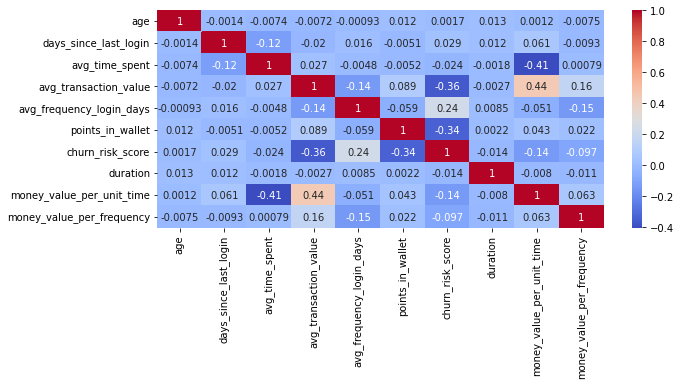

In [ ]:
plt.figure(figsize=(10,4))
corr = df2.corr()
sns.heatmap(corr, cmap="coolwarm", annot=True)

#### (2) Correlation between categorical features and targets (churn risk and money value)

Based on boxplot:
1. There is a obvious relationship between: membership_category and churn_risk_score, membership_category and money value.
2. There is a obvious relationship between: feedback and churn_risk_score. Positive feedback relates to low churn risk, negtive and netural (no reason specified) feedback relates to high churn risk.
3. There is some relationship between preferred_offer_types and money value.

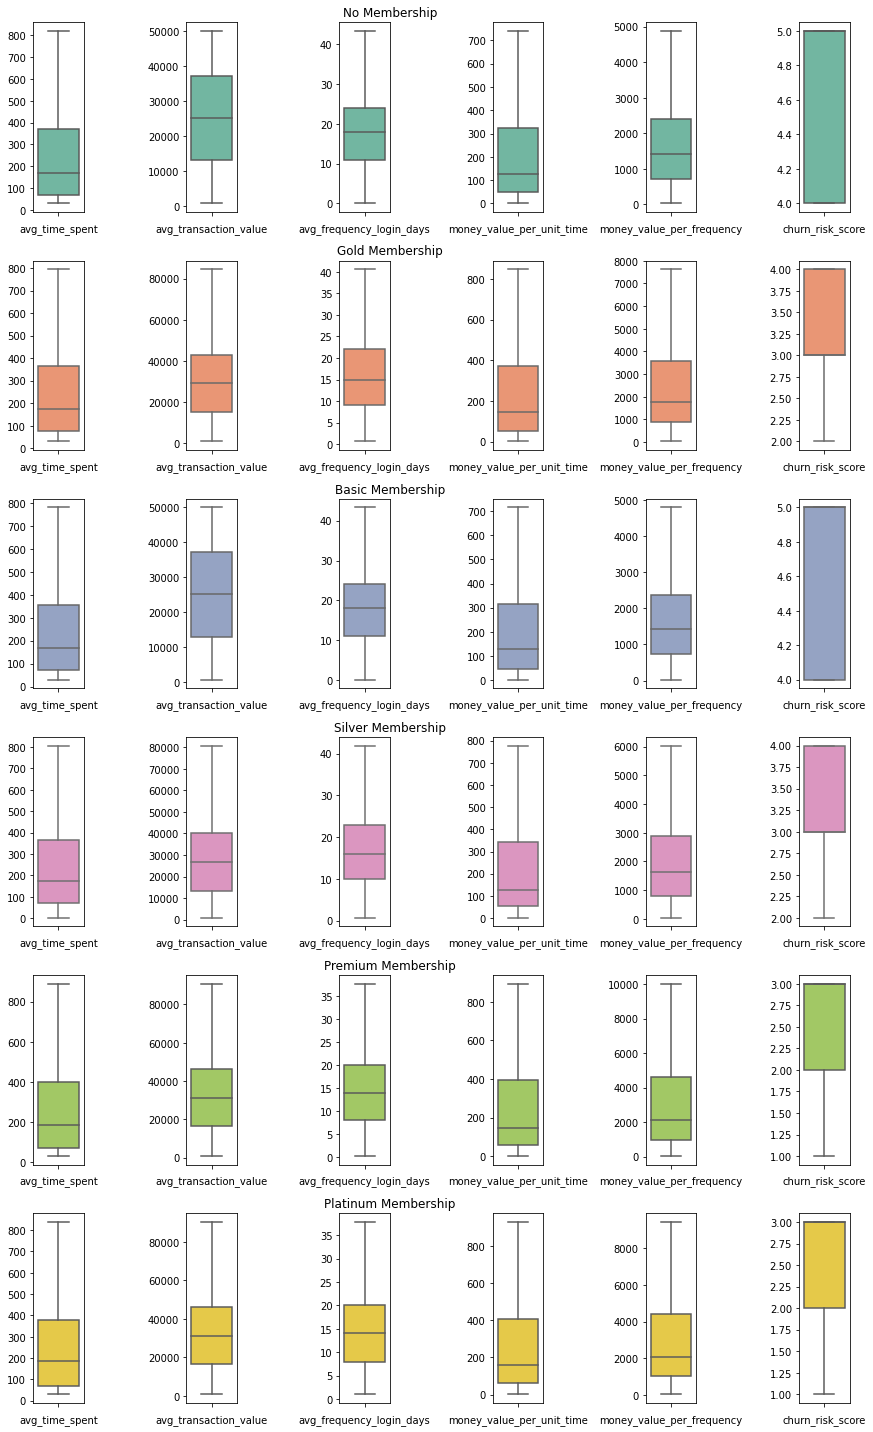

In [ ]:
# Membership_category vs.Churn_risk_score and Monny value

PALETTE = sns.color_palette("Set2")

fig, axes = plt.subplots(6, 6, figsize=(12, 20))

for i, value in enumerate(df2['membership_category'].unique()):
    sns.boxplot(data=df2.query(f'membership_category == "{value}"'), y='avg_time_spent', showfliers=False, color=PALETTE[i], ax=axes[i, 0])
    #axes[i, 0].set_ylim(0, 100)
    axes[i, 0].set_xlabel('avg_time_spent')
    axes[i, 0].set_ylabel('')
    
    sns.boxplot(data=df2.query(f'membership_category == "{value}"'), y='avg_transaction_value', showfliers=False, color=PALETTE[i], ax=axes[i, 1])
    axes[i, 1].set_xlabel('avg_transaction_value')
    axes[i, 1].set_ylabel('')
    
    sns.boxplot(data=df2.query(f'membership_category == "{value}"'), y='avg_frequency_login_days', showfliers=False, color=PALETTE[i], ax=axes[i, 2])
    axes[i, 2].set_xlabel('avg_frequency_login_days')
    axes[i, 2].set_ylabel('')
    axes[i, 2].set_title(f'{value}', x=1)
    
    sns.boxplot(data=df2.query(f'membership_category == "{value}"'), y='money_value_per_unit_time', showfliers=False, color=PALETTE[i], ax=axes[i, 3])
    axes[i, 3].set_xlabel('money_value_per_unit_time')
    axes[i, 3].set_ylabel('')
    
    sns.boxplot(data=df2.query(f'membership_category == "{value}"'), y='money_value_per_frequency', showfliers=False, color=PALETTE[i], ax=axes[i, 4])
    axes[i, 4].set_xlabel('money_value_per_frequency')
    axes[i, 4].set_ylabel('')
    
    sns.boxplot(data=df2.query(f'membership_category == "{value}"'), y='churn_risk_score', showfliers=False, color=PALETTE[i], ax=axes[i, 5])
    axes[i, 5].set_xlabel('churn_risk_score')
    axes[i, 5].set_ylabel('')
    
plt.tight_layout()


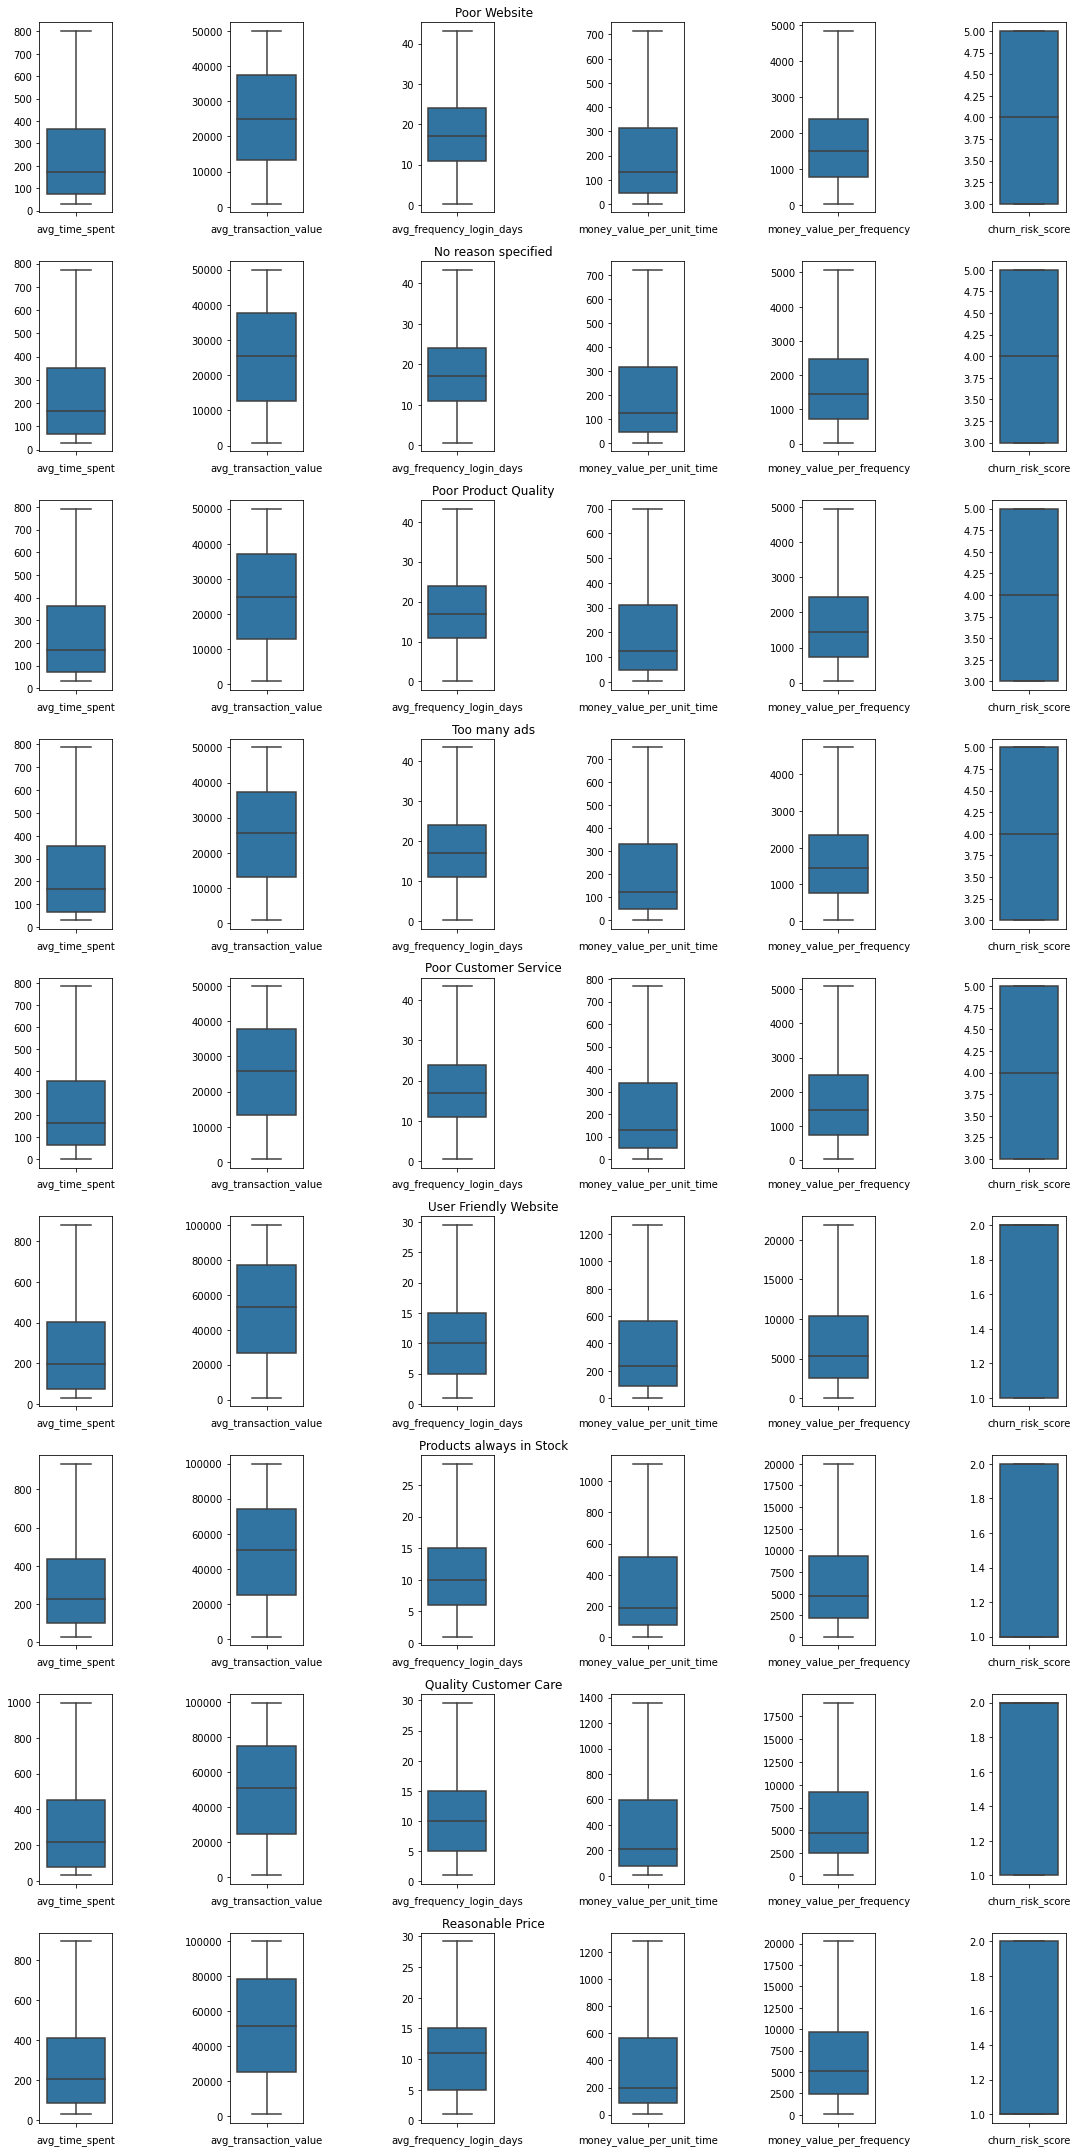

In [ ]:
# Feedback vs.Churn_risk_score and Monny value

fig, axes = plt.subplots(9, 6, figsize=(15,30))

for i, value in enumerate(df2['feedback'].unique()):
    sns.boxplot(data=df2.query(f'feedback == "{value}"'), y='avg_time_spent', showfliers=False, ax=axes[i, 0])
    axes[i, 0].set_xlabel('avg_time_spent')
    axes[i, 0].set_ylabel('')
    
    sns.boxplot(data=df2.query(f'feedback == "{value}"'), y='avg_transaction_value', showfliers=False, ax=axes[i, 1])
    axes[i, 1].set_xlabel('avg_transaction_value')
    axes[i, 1].set_ylabel('')
    
    sns.boxplot(data=df2.query(f'feedback == "{value}"'), y='avg_frequency_login_days', showfliers=False, ax=axes[i, 2])
    axes[i, 2].set_xlabel('avg_frequency_login_days')
    axes[i, 2].set_ylabel('')
    axes[i, 2].set_title(f'{value}', x=1)
    
    sns.boxplot(data=df2.query(f'feedback == "{value}"'), y='money_value_per_unit_time', showfliers=False, ax=axes[i, 3])
    axes[i, 3].set_xlabel('money_value_per_unit_time')
    axes[i, 3].set_ylabel('')
    
    sns.boxplot(data=df2.query(f'feedback == "{value}"'), y='money_value_per_frequency', showfliers=False, ax=axes[i, 4])
    axes[i, 4].set_xlabel('money_value_per_frequency')
    axes[i, 4].set_ylabel('')
    
    sns.boxplot(data=df2.query(f'feedback == "{value}"'), y='churn_risk_score', showfliers=False, ax=axes[i, 5])
    axes[i, 5].set_xlabel('churn_risk_score')
    axes[i, 5].set_ylabel('')
    
plt.tight_layout()


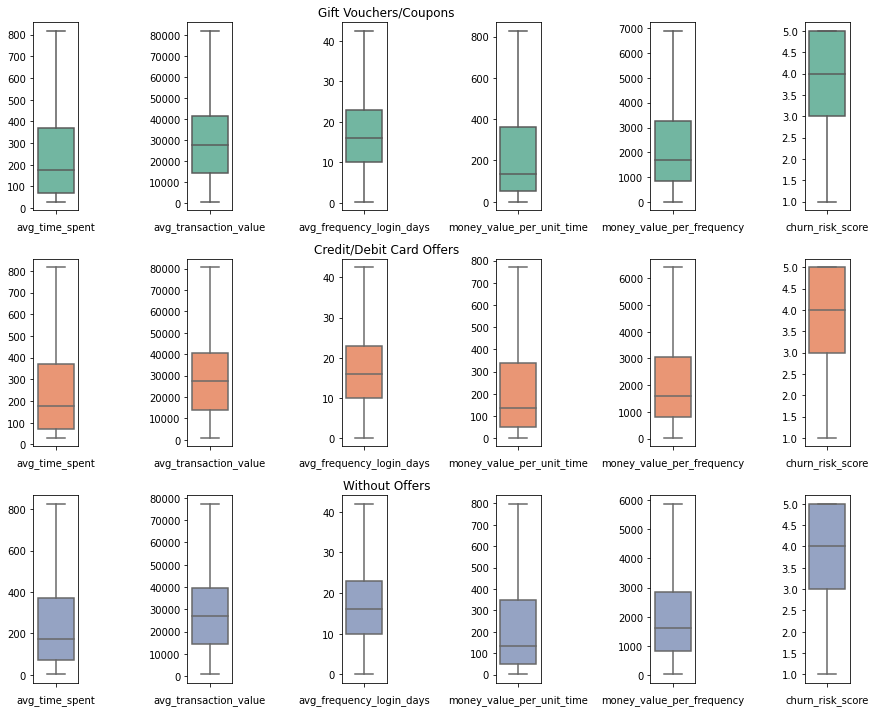

In [ ]:
# Preferred_offer_types vs.Churn_risk_score and Monny value

fig, axes = plt.subplots(3, 6, figsize=(12, 10))

for i, value in enumerate(df2['preferred_offer_types'].unique()):
    sns.boxplot(data=df2.query(f'preferred_offer_types == "{value}"'), y='avg_time_spent', showfliers=False, color=PALETTE[i], ax=axes[i, 0])
    #axes[i, 0].set_ylim(0, 100)
    axes[i, 0].set_xlabel('avg_time_spent')
    axes[i, 0].set_ylabel('')
    
    sns.boxplot(data=df2.query(f'preferred_offer_types == "{value}"'), y='avg_transaction_value', showfliers=False, color=PALETTE[i], ax=axes[i, 1])
    axes[i, 1].set_xlabel('avg_transaction_value')
    axes[i, 1].set_ylabel('')
    
    sns.boxplot(data=df2.query(f'preferred_offer_types == "{value}"'), y='avg_frequency_login_days', showfliers=False, color=PALETTE[i], ax=axes[i, 2])
    axes[i, 2].set_xlabel('avg_frequency_login_days')
    axes[i, 2].set_ylabel('')
    axes[i, 2].set_title(f'{value}', x=1)
    
    sns.boxplot(data=df2.query(f'preferred_offer_types == "{value}"'), y='money_value_per_unit_time', showfliers=False, color=PALETTE[i], ax=axes[i, 3])
    axes[i, 3].set_xlabel('money_value_per_unit_time')
    axes[i, 3].set_ylabel('')
    
    sns.boxplot(data=df2.query(f'preferred_offer_types == "{value}"'), y='money_value_per_frequency', showfliers=False, color=PALETTE[i], ax=axes[i, 4])
    axes[i, 4].set_xlabel('money_value_per_frequency')
    axes[i, 4].set_ylabel('')
    
    sns.boxplot(data=df2.query(f'preferred_offer_types == "{value}"'), y='churn_risk_score', showfliers=False, color=PALETTE[i], ax=axes[i, 5])
    axes[i, 5].set_xlabel('churn_risk_score')
    axes[i, 5].set_ylabel('')
    
plt.tight_layout()


#### (3) Feature Engineering After Box Plot

In [ ]:
#Turning the feedback column into sentiments 
sentiment = []
n = ['No reason specified']
p = ['User Friendly Website','Reasonable Price','Quality Customer Care','Products always in Stock']
for i, r in df2.iterrows():
    if r['feedback'] in n:
        sentiment.append('neutral')
    elif r['feedback'] in p:
        sentiment.append('positive')
    else:
        sentiment.append('negative')

df2['feedback'] = sentiment

In [ ]:
df2['feedback'].value_counts()

negative    12714
neutral      3114
positive     2840
Name: feedback, dtype: int64

In [ ]:
#Re-grouping Memberships into three groups 
mem_groups = []
for i, r in df2.iterrows():
    if r['membership_category'] in ['No Membership','Basic Membership']:
        mem_groups.append('Low Membership')
    elif r['membership_category'] in ['Premium Membership','Platinum Membership']:
        mem_groups.append('High Membership')
    else:
        mem_groups.append('Medium Membership')
df2['membership_category'] = mem_groups

In [ ]:
df2['membership_category'].value_counts()

Low Membership       7701
Medium Membership    6530
High Membership      4437
Name: membership_category, dtype: int64

#### (4) Distribution of independent variables w.r.t. dependent variable (churn risk score)

Churn_risk_score:
1: 7.54%; 2: 7.68%; 3: 29.26%; 4: 28.33%; 5: 27.2%

Based on density plots, we can see following features may be important for churn risk score prediction:
1. avg_transaction_value
2. avg_frequency_login_days
3. points_in_wallet

Based on count plots and crosstab table, we can see following features may be important for churn risk score prediction:
1. region_category
2. membership_category
3. feedback

In [ ]:
df2['churn_risk_score'].value_counts()/len(df2)

3    0.292586
4    0.283265
5    0.272016
2    0.076762
1    0.075370
Name: churn_risk_score, dtype: float64

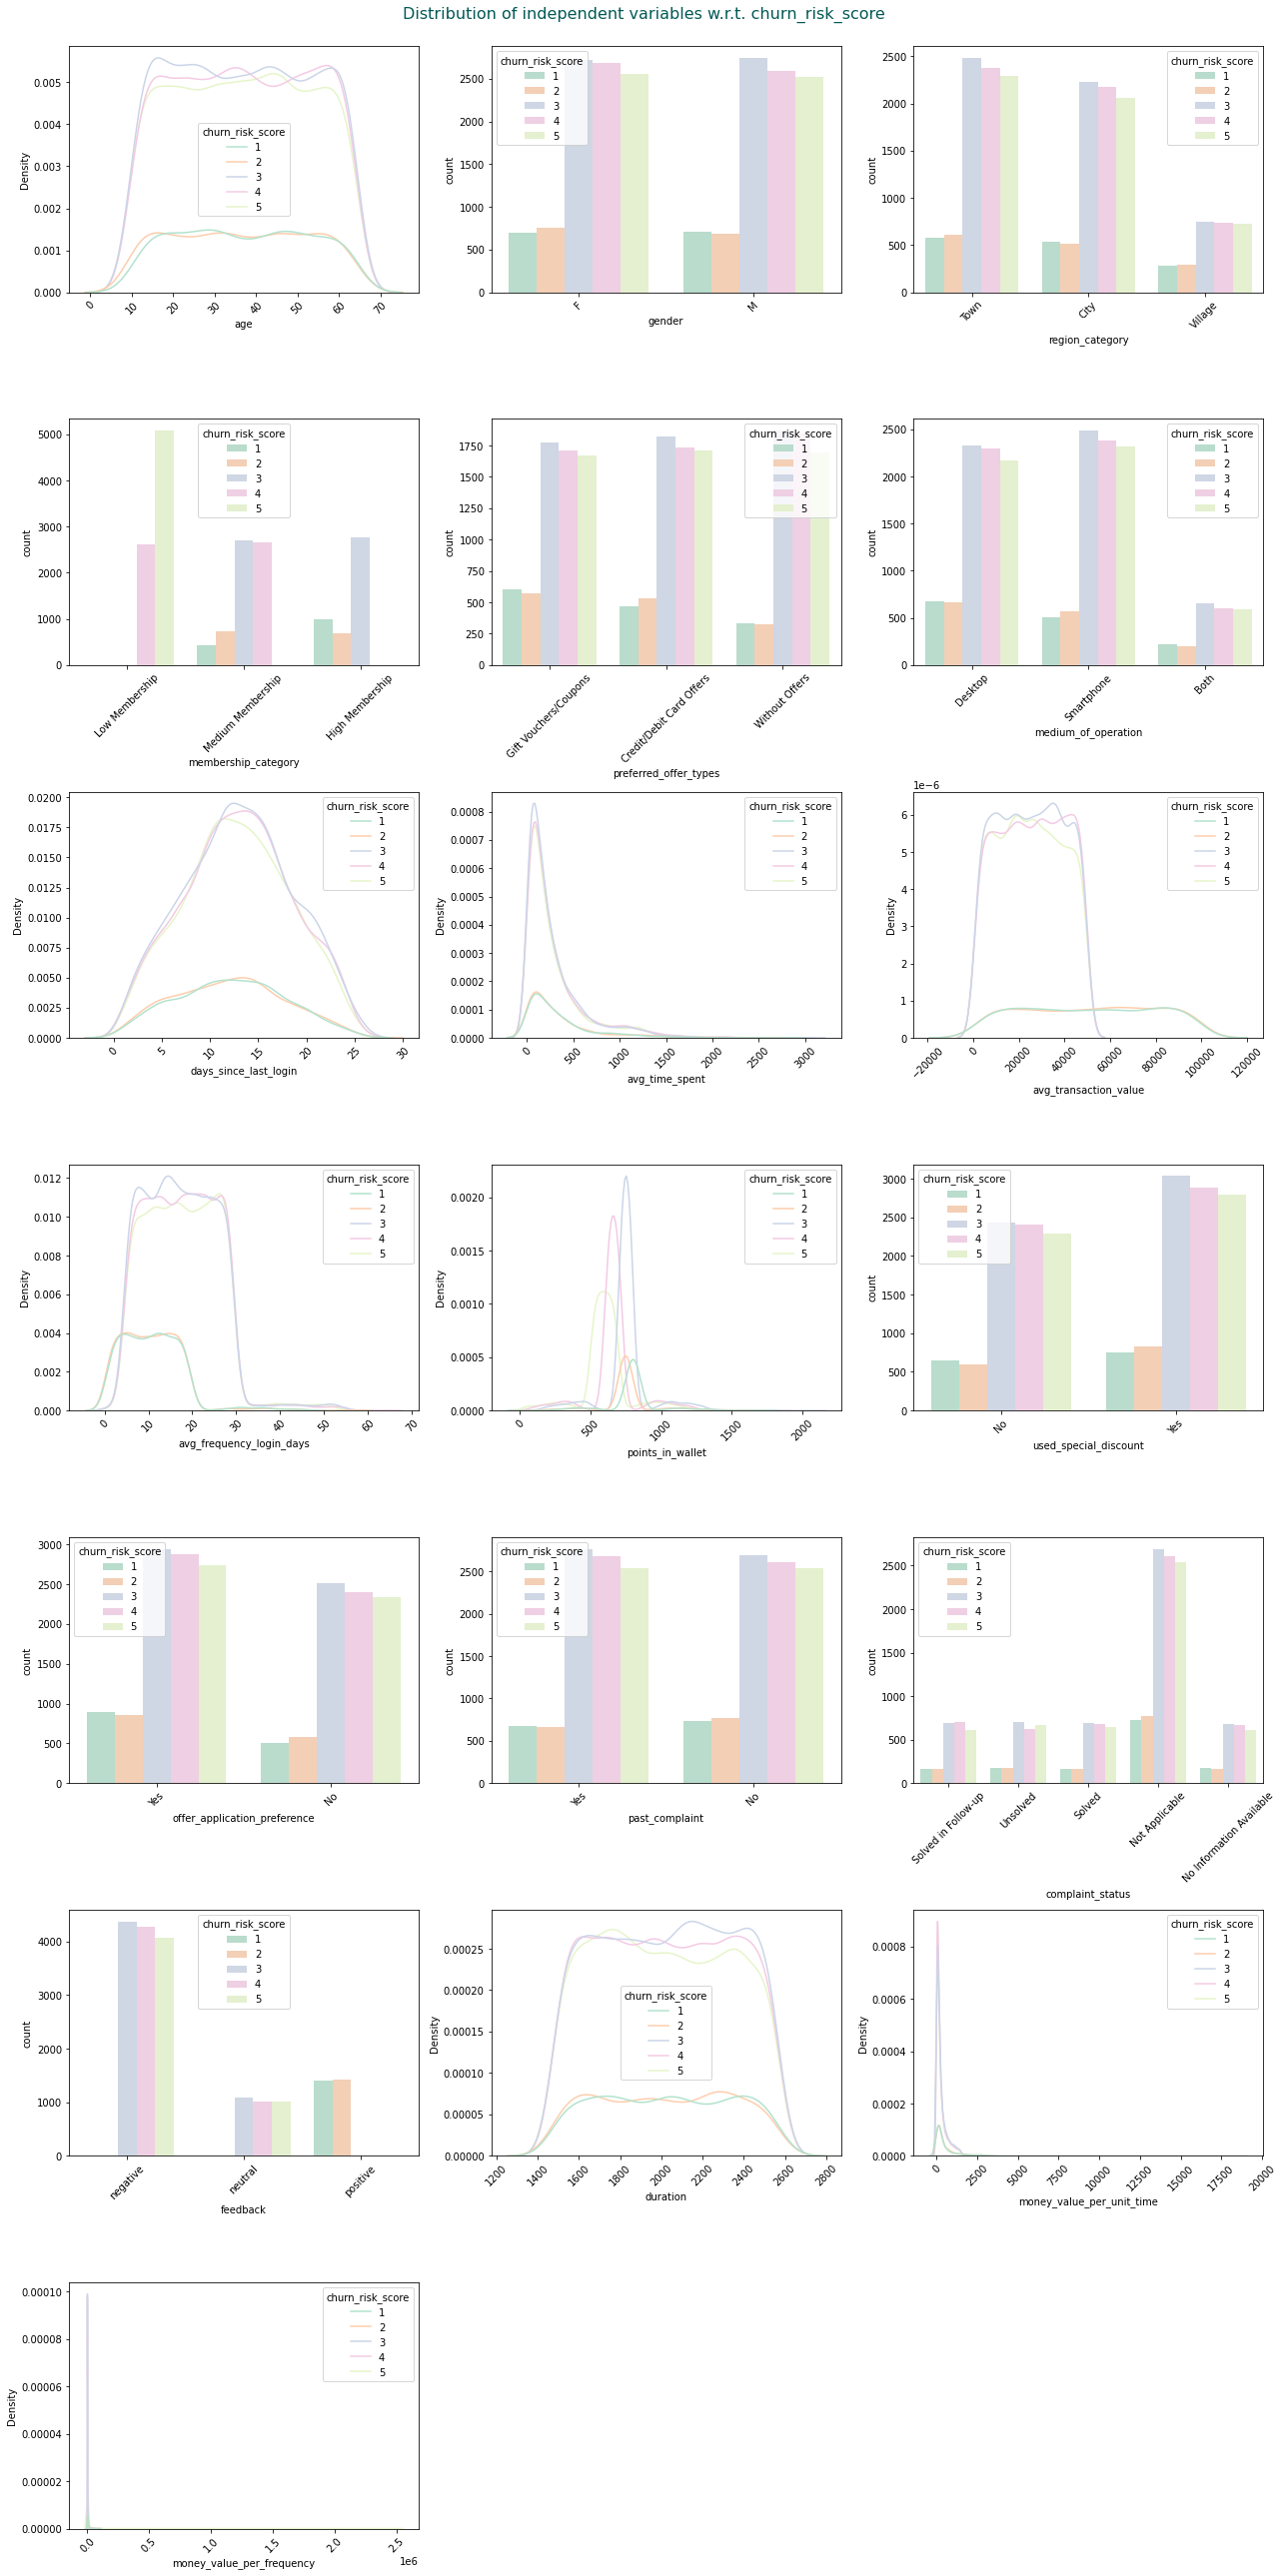

In [ ]:
plt.figure(figsize=(18,40))
i = 1
for column in df2.columns:
  if column not in ['churn_risk_score']:
    if df2[column].dtype == 'object':
      plt.subplot(8,3,i)
      sns.countplot(x=column, hue='churn_risk_score', data=df2, palette='Pastel2')
      i += 1
      plt.xticks(rotation=45)
    elif df2[column].dtype in ['float64','int64']:
      plt.subplot(8,3,i)
      sns.kdeplot(x=column, hue='churn_risk_score', data=df2, palette='Pastel2')
      i+=1
      plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle('Distribution of independent variables w.r.t. churn_risk_score', size=16, color='#025955',y=1.01)
plt.show()

In [ ]:
def perc(x):
  return x/sum(x)
pd.crosstab(index=df2['churn_risk_score'], columns=df2['region_category']).apply(perc)

region_category,City,Town,Village
churn_risk_score,,,
1,0.071742,0.069957,0.101325
2,0.069085,0.073670,0.106695
3,0.296134,0.297437,0.268528
4,0.289225,0.284739,0.262800
5,0.273814,0.274197,0.260652


In [ ]:
pd.crosstab(index=df2['churn_risk_score'], columns=df2['membership_category']).apply(perc)

membership_category,High Membership,Low Membership,Medium Membership
churn_risk_score,,,
1,0.221095,0.000000,0.065237
2,0.157088,0.000000,0.112711
3,0.621817,0.000000,0.413936
4,0.000000,0.340605,0.408116
5,0.000000,0.659395,0.000000


In [ ]:
pd.crosstab(index=df2['churn_risk_score'], columns=df2['feedback']).apply(perc)

feedback,negative,neutral,positive
churn_risk_score,,,
1,0.000000,0.000000,0.495423
2,0.000000,0.000000,0.504577
3,0.344188,0.348748,0.000000
4,0.335614,0.327874,0.000000
5,0.320198,0.323378,0.000000


In [ ]:
pd.crosstab(index=df2['churn_risk_score'], columns=df2['medium_of_operation']).apply(perc)

medium_of_operation,Both,Desktop,Smartphone
churn_risk_score,,,
1,0.099119,0.083108,0.061229
2,0.088106,0.081264,0.069216
3,0.286344,0.285960,0.300823
4,0.266960,0.282395,0.288601
5,0.259471,0.267273,0.280131


In [ ]:
pd.crosstab(index=df2['churn_risk_score'], columns=df2['used_special_discount']).apply(perc)

used_special_discount,No,Yes
churn_risk_score,,
1,0.078136,0.073121
2,0.071565,0.080987
3,0.289964,0.294717
4,0.286738,0.280443
5,0.273596,0.270732


#### (5) Distribution of independent variables w.r.t. dependent variable (avg_transaction_value)

1. Feedback is also important for avg_transaction_value prediction.
2. Membership and complaint_status can have some impact.
3. avg_time_spent and avg_frequency_login_days have a negtive correlation.
  
  avg_time_spent represents the average time spent by a customer on the website; avg_frequency_login_days represents the no. of times a customer has logged in to the website 
4. 'money_value_per_unit_time' and 'money_value_per_frequency' do not give us more information.

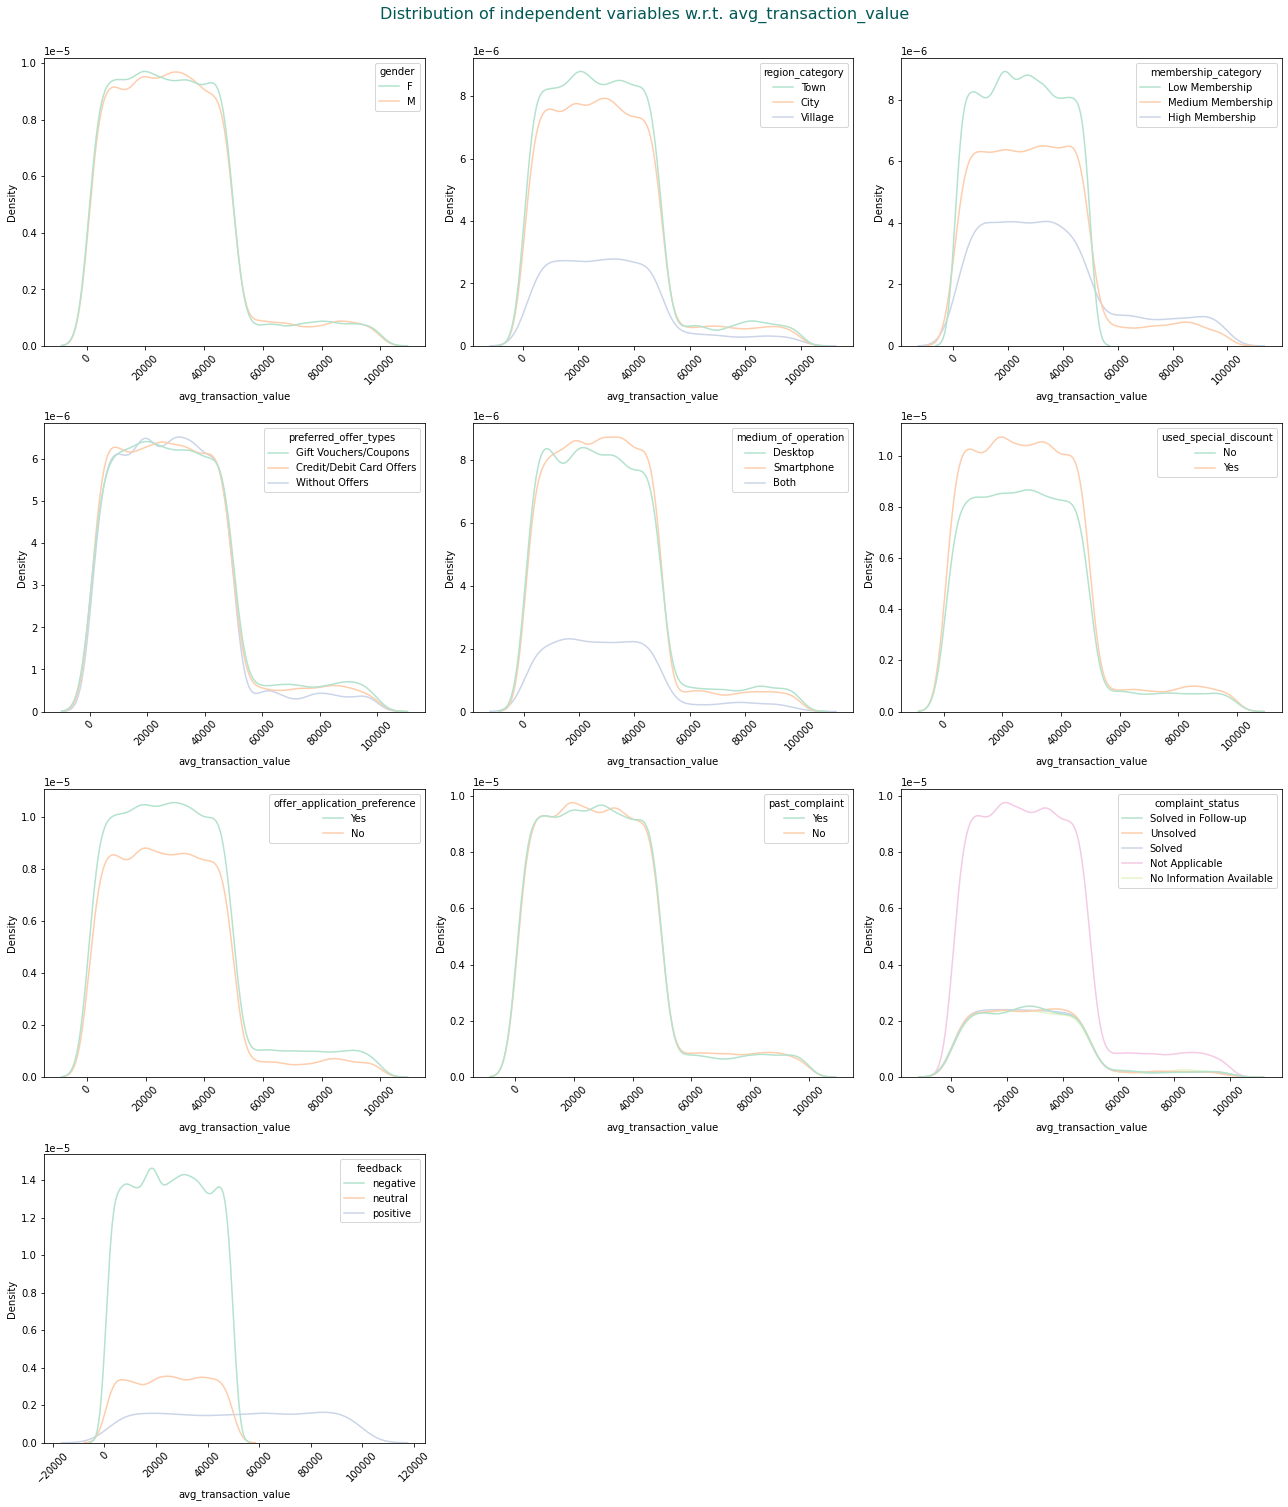

In [ ]:
plt.figure(figsize=(18,40))
i = 1
for column in df2.columns:
  if column not in ['churn_risk_score','avg_transaction_value']:
    if df2[column].dtype == 'object':
      plt.subplot(8,3,i)
      sns.kdeplot(x='avg_transaction_value', hue=column, data=df2, palette='Pastel2')
      i += 1
      plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle('Distribution of independent variables w.r.t. avg_transaction_value', size=16, color='#025955',y=1.01)
plt.show()

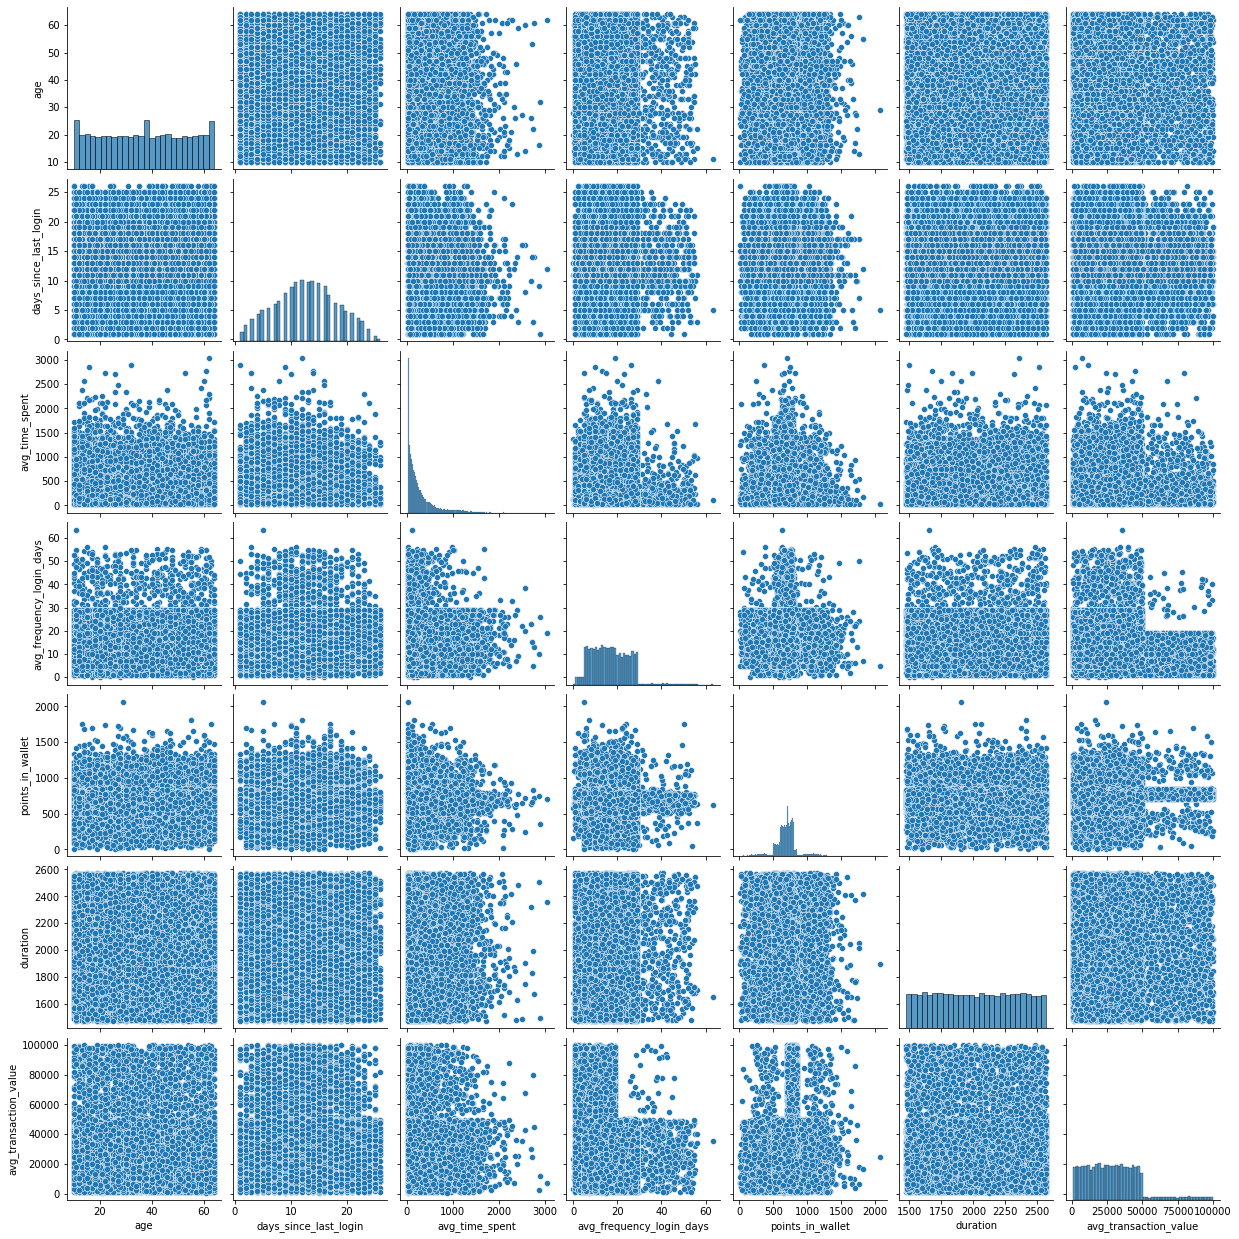

In [ ]:
df3 = df2[['age','days_since_last_login','avg_time_spent','avg_frequency_login_days',
      'points_in_wallet','duration','avg_transaction_value']]
sns.pairplot(df3)
plt.show()

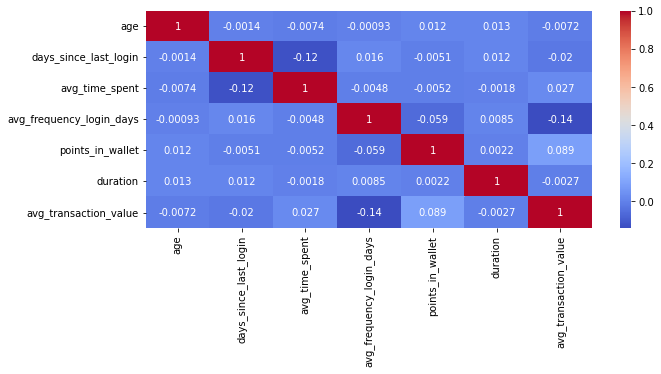

In [ ]:
plt.figure(figsize=(10,4))
corr = df3.corr()
sns.heatmap(corr, cmap="coolwarm", annot=True)

### Part 4: Cluster Analysis

After performing cluster analysis, we did not get a valuable result. We think it is because the dataset we used does not have clear customer segmentations.

In [ ]:
# K-Means Clustering with Python: https://medium.com/analytics-vidhya/clustering-on-mixed-data-types-in-python-7c22b3898086

# convert categorical features into numerical ones
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
df_norm = df2[['age','gender','region_category','membership_category','preferred_offer_types','medium_of_operation','days_since_last_login',
        'avg_time_spent','avg_transaction_value','avg_frequency_login_days','points_in_wallet','complaint_status','feedback','duration']]
scaler = preprocessing.MinMaxScaler()
df_norm[['age','days_since_last_login','avg_time_spent','avg_transaction_value',
    'avg_frequency_login_days','points_in_wallet','duration']] = scaler.fit_transform(df_norm[['age','days_since_last_login','avg_time_spent',
                                                  'avg_transaction_value','avg_frequency_login_days','points_in_wallet','duration']])

In [ ]:
df_norm_dummy = pd.get_dummies(df_norm, columns=['gender','region_category','membership_category','preferred_offer_types','medium_of_operation','complaint_status','feedback'])

In [ ]:
df_norm_dummy.head()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,duration,gender_F,gender_M,region_category_City,region_category_Town,region_category_Village,membership_category_High Membership,membership_category_Low Membership,membership_category_Medium Membership,preferred_offer_types_Credit/Debit Card Offers,preferred_offer_types_Gift Vouchers/Coupons,preferred_offer_types_Without Offers,medium_of_operation_Both,medium_of_operation_Desktop,medium_of_operation_Smartphone,complaint_status_No Information Available,complaint_status_Not Applicable,complaint_status_Solved,complaint_status_Solved in Follow-up,complaint_status_Unsolved,feedback_negative,feedback_neutral,feedback_positive
2,0.629630,0.52,0.169265,0.204074,0.346234,0.239624,0.378995,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0
3,0.500000,0.40,0.016927,0.246577,0.094322,0.272092,0.390868,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0
4,0.388889,0.76,0.036627,0.238950,0.251767,0.318344,0.100457,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
6,0.203704,0.36,0.017621,0.082552,0.440700,0.363504,0.929680,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0
10,0.277778,0.52,0.187059,0.346264,0.125811,0.336107,0.536986,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0


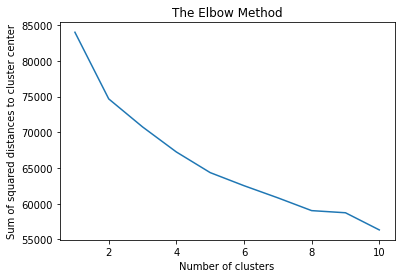

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use elbow method to find optimal number of clusters
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(df_norm_dummy)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances to cluster center')
plt.show()

# no elbow. is it because we use too many features?

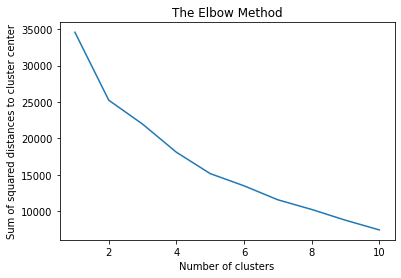

In [ ]:
# how about focusing on some basic customer info, like age, gender, region, membership
df_norm_test = df_norm[['age','gender','region_category','membership_category']]
df_norm_test_dummy = pd.get_dummies(df_norm_test, columns=['gender','region_category','membership_category'])

cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(df_norm_test_dummy)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances to cluster center')
plt.show()

# maybe we can divide our customers into 5 segments? 
# or we can explore other combination of features (including categorical and numerical ones)?

In [ ]:
# fit a cluster model with k=5
kmeans = KMeans(5)
clusters = kmeans.fit_predict(df_norm_test_dummy)
labels = pd.DataFrame(clusters)
df4 = df_norm[['age','gender','region_category','membership_category']]
df4['cluster'] = labels+1

In [ ]:
df4.head() 
# Question 1: how to interpret these 5 cluster?
# Question 2: or cluster with important features, such as membership_category and feedback for churn_risk_score? (like example in session 7)

,age,gender,region_category,membership_category,cluster
2,0.629630,F,Town,Low Membership,3.0
3,0.500000,M,City,Low Membership,2.0
4,0.388889,F,City,Low Membership,3.0
6,0.203704,M,Town,Medium Membership,2.0
10,0.277778,F,Village,Low Membership,5.0


### Part 5: Regression Models

In [ ]:
# define a function to report coefficients and odds
def coef(model):
    print('Intercept: \n', [round(i, 2) for i in model.intercept_])
    print()
    print('Coefficients:')
    for i in model.coef_:
        print([round(j, 2) for j in i])
    print()
    print('Odds ratios:')
    for i in np.exp(model.coef_):
        print([round(j, 2) for j in i])

In [ ]:
# report accuracy statistics
def acc(test_data, model, test_data_scaled):
    class_report=classification_report(test_data, model.predict(test_data_scaled))
    print(class_report)

In [ ]:
# define a function for data normalization
def scale (x):
    scaler = StandardScaler()
    num_d_train = x[['points_in_wallet']] # get numeric data
    x_scaled = x.copy()
    x_scaled[num_d_train.columns] = scaler.fit_transform(num_d_train) # update the cols with their normalized values
    #x_scaled = pd.get_dummies(data=x_scaled)    # convert string variable to One Hot Encoding
    #x_scaled.drop(['region_category_Village','membership_category_High Membership','feedback_positive'], axis=1, inplace=True)
    
    return x_scaled

# scaler.inverse_transform(X2_test_scaled[num_d_train.columns])  # function to restore the original values, given the transformation

#### (1) Model 1: Linear Regression

We use linear regression to select important features: 'points_in_wallet', 'membership_category', 'feedback'.

In [ ]:
y1 = df2['churn_risk_score']

In [ ]:
X1 = df2[['avg_frequency_login_days','points_in_wallet','avg_transaction_value',
         'region_category','membership_category','feedback']]

In [ ]:
X1 = pd.get_dummies(data=X1)
X1.drop(['region_category_Village','membership_category_High Membership','feedback_positive'], axis=1, inplace=True)

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=1)

In [ ]:
X1_train_cst = sm.add_constant(X1_train)
est = sm.OLS(y1_train, X1_train_cst)
est1 = est.fit()
print(est1.summary())

                            OLS Regression Results                            
Dep. Variable:       churn_risk_score   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     8715.
Date:                Sat, 15 Jan 2022   Prob (F-statistic):               0.00
Time:                        21:48:12   Log-Likelihood:                -7936.4
No. Observations:               13067   AIC:                         1.589e+04
Df Residuals:                   13057   BIC:                         1.597e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

#### (2) Model 2: Binary Prediction for 'churn_risk_score'

In [ ]:
y2 = df2['churn_risk_score'].copy()

In [ ]:
for i in y2.index:
    if y2[i] >= 4:
        y2[i] = 1
    else:
        y2[i] = 0
y2.value_counts()

1    10366
0     8302
Name: churn_risk_score, dtype: int64

In [ ]:
8302/(8302+10366)

0.44471823441182773

In [ ]:
X2 = df2[['points_in_wallet','membership_category','feedback']]

In [ ]:
X2 = pd.get_dummies(data=X2)
X2.drop(['membership_category_High Membership','feedback_positive'], axis=1, inplace=True)

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=1)

In [ ]:
X2_train_cst = sm.add_constant(X2_train)
clf = sm.Logit(y2_train, X2_train_cst)
clf1 = clf.fit()
print(clf1.summary())
# print(clf1.summary2()) can also print this summary report

         Current function value: 0.190681
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:       churn_risk_score   No. Observations:                13067
Model:                          Logit   Df Residuals:                    13061
Method:                           MLE   Df Model:                            5
Date:                Sat, 15 Jan 2022   Pseudo R-squ.:                  0.7222
Time:                        21:49:49   Log-Likelihood:                -2491.6
converged:                      False   LL-Null:                       -8970.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                   -35.4915   5357.688     -0.007      0.995   -1.05e

In [ ]:
lr = LogisticRegression()
lr.fit(X2_train, y2_train)

coef(lr)

Intercept: 
 [-4.03]

Coefficients:
[-0.0, 12.82, 4.34, 2.48, 2.09]

Odds ratios:
[1.0, 371294.23, 76.98, 11.97, 8.12]


In [ ]:
confmtrx = np.array(confusion_matrix(y2_test, lr.predict(X2_test)))
pd.DataFrame(confmtrx,index=['0','1'],columns=['predicted_0','predicted_1'])

,predicted_0,predicted_1
0,2405,118
1,228,2850


In [ ]:
acc(y2_test, lr, X2_test)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2523
           1       0.96      0.93      0.94      3078

    accuracy                           0.94      5601
   macro avg       0.94      0.94      0.94      5601
weighted avg       0.94      0.94      0.94      5601



#### (3) Model 3: Multi Class Prediction for 'churn_risk_score'¶

In [ ]:
y3 = df2['churn_risk_score']

In [ ]:
X3 = df2[['points_in_wallet','membership_category','feedback']]

In [ ]:
X3 = pd.get_dummies(data=X3)
X3.drop(['membership_category_High Membership','feedback_positive'], axis=1, inplace=True)

In [ ]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=1)

In [ ]:
mclf = LogisticRegression(multi_class='multinomial', class_weight='balanced')
mclf.fit(X3_train, y3_train)

coef(mclf)

Intercept: 
 [-1.29, 0.19, -0.46, 1.22, 0.33]

Coefficients:
[0.01, -4.47, 0.02, -6.96, -3.55]
[0.0, -4.11, 1.01, -6.57, -3.75]
[0.0, -4.55, -0.41, 5.28, 3.24]
[-0.01, 4.89, 3.42, 4.79, 2.75]
[-0.01, 8.25, -4.05, 3.46, 1.31]

Odds ratios:
[1.01, 0.01, 1.02, 0.0, 0.03]
[1.0, 0.02, 2.76, 0.0, 0.02]
[1.0, 0.01, 0.66, 196.95, 25.64]
[0.99, 132.32, 30.64, 120.79, 15.57]
[0.99, 3811.81, 0.02, 31.73, 3.69]


In [ ]:
confmtrx = np.array(confusion_matrix(y3_test, mclf.predict(X3_test)))
pd.DataFrame(confmtrx,index=['1','2','3','4','5'],columns=['predicted_1','predicted_2','predicted_3','predicted_4','predicted_5'])

,predicted_1,predicted_2,predicted_3,predicted_4,predicted_5
1,302,131,0,6,0
2,215,207,0,11,0
3,1,0,1514,136,0
4,3,0,115,665,785
5,1,0,2,0,1507


In [ ]:
acc(y3_test, mclf, X3_test)

              precision    recall  f1-score   support

           1       0.58      0.69      0.63       439
           2       0.61      0.48      0.54       433
           3       0.93      0.92      0.92      1651
           4       0.81      0.42      0.56      1568
           5       0.66      1.00      0.79      1510

    accuracy                           0.75      5601
   macro avg       0.72      0.70      0.69      5601
weighted avg       0.77      0.75      0.73      5601



#### (4) Model 4: Ordinal Logistic Regression

Reference:

https://rikunert.com/ordinal_rating

https://medium.datadriveninvestor.com/logistic-regression-simple-multinomial-and-ordinal-b2bc886bb974

https://pythonhosted.org/mord/index.html

In [101]:
pip install mord

  Created wheel for mord: filename=mord-0.6-py3-none-any.whl size=6006 sha256=38bc9c22fa95596a570174bb1e5d3d1bfc3226815df257db290d42eb6c936b0b
  Stored in directory: /root/.cache/pip/wheels/80/1d/8a/bef1a01b6a3c91494905d161d5426c181819f9730a773141eb
Successfully built mord


In [113]:
# choose models  
from mord import LogisticAT

# instantiate models   
model_ordinal = LogisticAT(alpha=0, verbose=0)  # alpha parameter set to zero to perform no regularisation 

In [115]:
y4 = df2['churn_risk_score']
X4 = df2[['points_in_wallet','membership_category','feedback']]

In [116]:
X4 = pd.get_dummies(data=X4)
X4.drop(['membership_category_High Membership','feedback_positive'], axis=1, inplace=True)

In [117]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3, random_state=1)

In [118]:
model_ordinal.fit(X4_train, y4_train)

LogisticAT(alpha=0)

In [120]:
confmtrx = np.array(confusion_matrix(y4_test, model_ordinal.predict(X4_test)))
pd.DataFrame(confmtrx,index=['1','2','3','4','5'],columns=['predicted_1','predicted_2','predicted_3','predicted_4','predicted_5'])

,predicted_1,predicted_2,predicted_3,predicted_4,predicted_5
1,303,136,0,0,0
2,200,233,0,0,0
3,0,0,1596,55,0
4,0,0,483,369,716
5,0,0,0,94,1416


In [121]:
acc(y3_test, model_ordinal, X3_test)

              precision    recall  f1-score   support

           1       0.60      0.69      0.64       439
           2       0.63      0.54      0.58       433
           3       0.77      0.97      0.86      1651
           4       0.71      0.24      0.35      1568
           5       0.66      0.94      0.78      1510

    accuracy                           0.70      5601
   macro avg       0.68      0.67      0.64      5601
weighted avg       0.70      0.70      0.66      5601



### Part 6: Insights and Recommendations

In [ ]:
df5 = df1[['membership_category','feedback','churn_risk_score']]

#### (1) Insights on Feedback

Company should think about how to improve regarding those negative feedback.

First priority: too many ads and poor product quality

Then: poor website and poor customer service

In [ ]:
df5['feedback'].value_counts()  # key words: website, product quality, customer service, ads, price, product supply

Poor Website                3202
Poor Product Quality        3193
Poor Customer Service       3163
Too many ads                3156
No reason specified         3114
User Friendly Website        723
Reasonable Price             716
Quality Customer Care        707
Products always in Stock     694
Name: feedback, dtype: int64

In [ ]:
df6 = pd.DataFrame(columns = ['key_words', 'positive', 'negative'])
df6['key_words'] = ['website', 'product quality', 'customer service', 'ads', 'price', 'product supply']
df6['positive'] = [1,0,1,0,1,1]
df6['negative'] = [1,1,1,1,0,0]

In [ ]:
df6.T

,0,1,2,3,4,5
key_words,website,product quality,customer service,ads,price,product supply
positive,1,0,1,0,1,1
negative,1,1,1,1,0,0


#### (2) Insights on Memberships
All low risk (1 or 2) customers give positive feedback. All high risk (3, 4 or 5) customers give negative and/or neutral feedback.

Within low risk group, we see that platinum and premium memberships can further lower churn risk from 2 to 1.

Within high risk group, we see that gold and silver memberships further lower churn risk from 5 to 4, and platinum and premium memberships can further lower churn risk from 4 to 3.

Therefore, we can conclude that membership has more influence on churn risk score. Company shall form strategies to motivate its customers to being a membership with a level above basic.

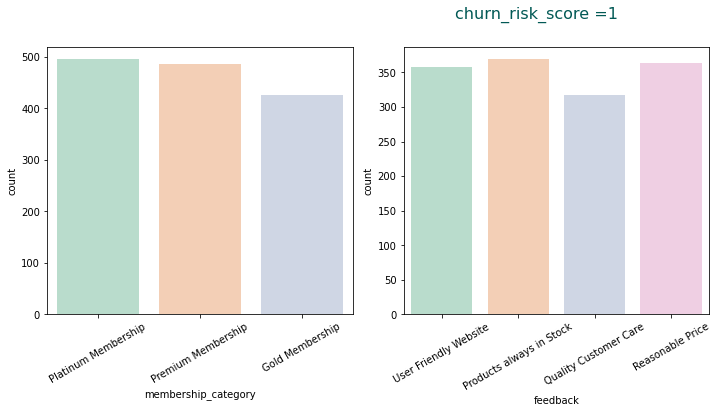

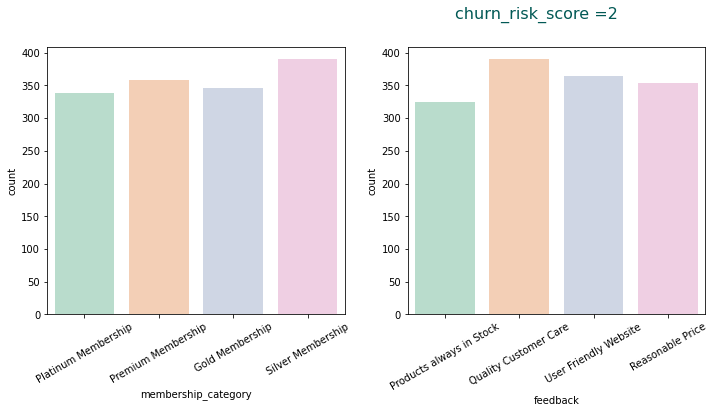

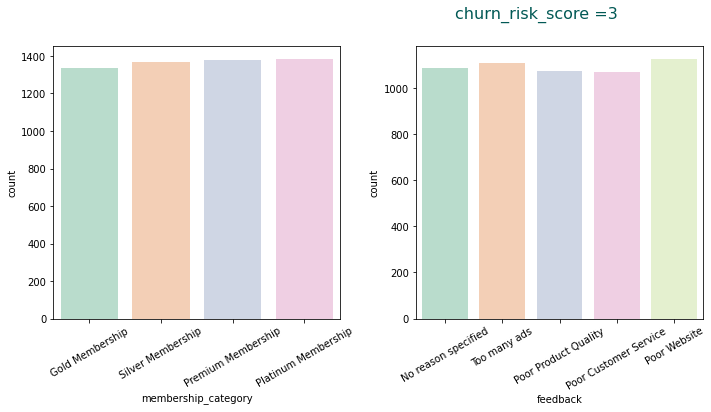

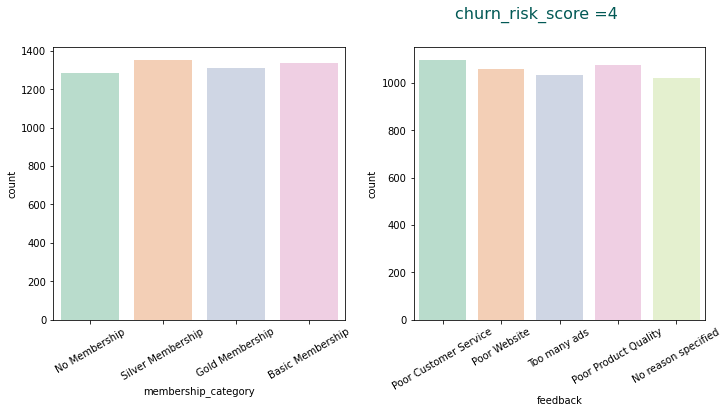

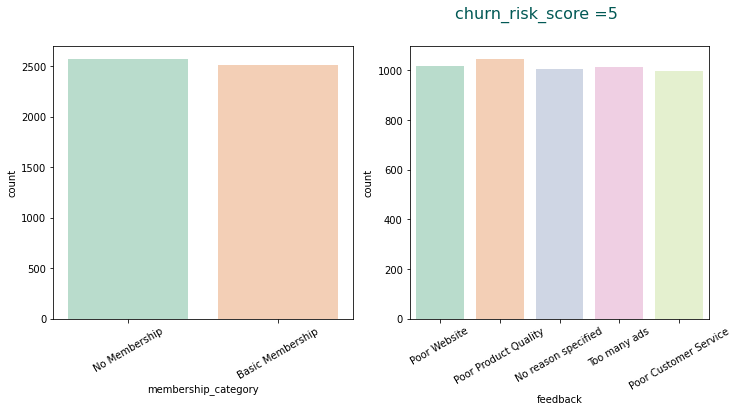

In [ ]:
for score in [1,2,3,4,5]:
    plt.figure(figsize=(15,40))
    df7 = df5[df5['churn_risk_score'] == score].copy()
    i = 1
    for column in df7.columns:
        if column not in ['churn_risk_score']:
            plt.subplot(8,3,i)
            sns.countplot(x=column, data=df7, palette='Pastel2')  # hue='churn_risk_score'
            i += 1
            plt.xticks(rotation=30)
    plt.tight_layout()
    plt.suptitle('churn_risk_score ='+str(score), size=16, color='#025955',y=1.01)
    plt.show()

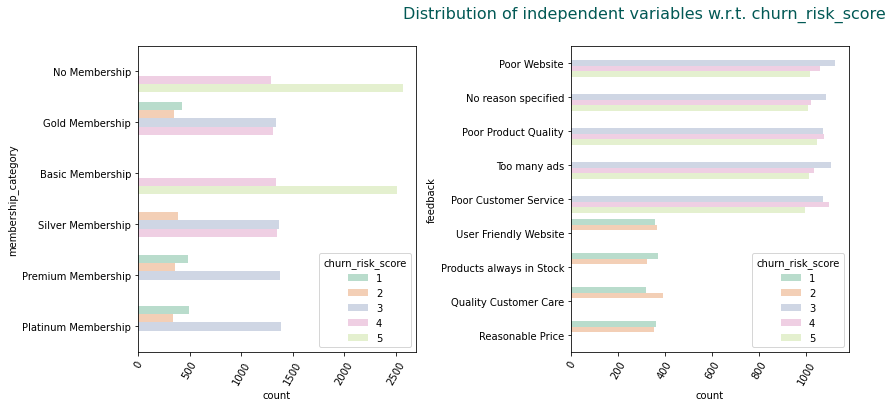

In [ ]:
plt.figure(figsize=(18,40))
i = 1
for column in df5.columns:
    if column not in ['churn_risk_score']:
        plt.subplot(8,3,i)
        sns.countplot(y=column, hue='churn_risk_score', data=df5, palette='Pastel2')
        i += 1
        plt.xticks(rotation=60)
plt.tight_layout()
plt.suptitle('Distribution of independent variables w.r.t. churn_risk_score', size=16, color='#025955',y=1.01)
plt.show()